# Macrodata Refinement (MDR) Quickstart

This notebook provides a comprehensive introduction to the Macrodata Refinement (MDR) library. MDR is a powerful toolkit for refining, validating, and transforming macrodata through various statistical and analytical methods.

## Table of Contents

1. [Setup and Installation](#1.-Setup-and-Installation)
2. [Generating Sample Data](#2.-Generating-Sample-Data)
3. [Data Validation](#3.-Data-Validation)
4. [Data Refinement](#4.-Data-Refinement)
5. [Data Transformation](#5.-Data-Transformation)
6. [Visualization](#6.-Visualization)
7. [File I/O](#7.-File-I-O)
8. [End-to-End Workflow](#8.-End-to-End-Workflow)
9. [Advanced Usage](#9.-Advanced-Usage)

Let's get started!

## 1. Setup and Installation

First, let's import the necessary packages and set up the environment.

In [1]:
# Install MDR if not already installed
# !pip install macrodata-refinement

# Standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# MDR imports
from mdr.core.refinement import RefinementConfig, refine_data, apply_refinement_pipeline
from mdr.core.validation import validate_data
from mdr.core.transformation import transform_data
from mdr.io.readers import read_csv, read_json
from mdr.io.writers import write_csv, write_json
from mdr.visualization.plots import (
    plot_time_series,
    plot_histogram,
    plot_boxplot,
    plot_refinement_comparison,
    plot_validation_results,
    save_plot,
    PlotConfig
)
from mdr.utils.logging import setup_logger, get_logger, LogLevel
from mdr.utils.helpers import detect_seasonality, interpolate_missing

# Set up logging
setup_logger(level=LogLevel.INFO)
logger = get_logger()

# Create output directory
output_dir = "mdr_notebook_output"
os.makedirs(output_dir, exist_ok=True)

print("Setup complete!")

Setup complete!


## 2. Generating Sample Data

Let's generate some sample data to work with. We'll create three variables with different characteristics:

- `temperature`: A sinusoidal pattern with some outliers and missing values
- `pressure`: A relatively stable variable with some drift and a few outliers
- `humidity`: A variable with strong seasonality and more noise

In [2]:
def generate_sample_data(num_points: int = 100, seed: int = 42) -> Dict[str, np.ndarray]:
    """
    Generate sample data for demonstration purposes.
    
    Args:
        num_points: Number of data points to generate
        seed: Random seed for reproducibility
        
    Returns:
        Dictionary of variable names to arrays
    """
    assert isinstance(num_points, int), "num_points must be an integer"
    assert num_points > 0, "num_points must be positive"
    assert isinstance(seed, int), "seed must be an integer"
    
    # Set random seed
    np.random.seed(seed)
    
    # Generate time points
    time = np.linspace(0, 10, num_points)
    
    # Generate temperature data (sinusoidal with outliers and missing values)
    temperature = 20.0 + 5.0 * np.sin(time) + 0.5 * np.random.randn(num_points)
    
    # Add outliers to temperature
    temperature[10] = 45.0  # High outlier
    temperature[30] = 5.0   # Low outlier
    
    # Add missing values to temperature
    temperature[20] = np.nan
    temperature[40:43] = np.nan
    
    # Generate pressure data (stable with drift)
    pressure = 101.3 + 0.01 * time + 0.05 * np.random.randn(num_points)
    
    # Add outliers to pressure
    pressure[25] = 102.5  # High outlier
    pressure[60] = 100.0  # Low outlier
    
    # Add missing values to pressure
    pressure[15] = np.nan
    pressure[50:53] = np.nan
    
    # Generate humidity data (seasonal with more noise)
    humidity = 50.0 + 15.0 * np.sin(time/2) + 3.0 * np.random.randn(num_points)
    
    # Add outliers to humidity
    humidity[5] = 95.0   # High outlier
    humidity[55] = 10.0  # Low outlier
    
    # Add missing values to humidity
    humidity[35] = np.nan
    humidity[70:73] = np.nan
    
    return {
        "time": time,
        "temperature": temperature,
        "pressure": pressure,
        "humidity": humidity
    }

# Generate the sample data
data = generate_sample_data(num_points=100)

# Extract time array and remove from data dictionary
time = data.pop("time")

# Display the first few values of each variable
pd.DataFrame(data).head(10)

,temperature,pressure,humidity
0,20.248357,101.229231,51.073362
1,20.435060,101.279978,52.439607
2,21.327089,101.284884,54.761730
3,22.253584,101.262916,55.425448
4,21.848606,101.295976,48.876725
5,22.302190,101.325253,95.000000
6,23.637777,101.400370,56.021313
7,23.631765,101.315800,56.734608
8,23.380076,101.320958,57.442192
9,24.216007,101.305369,68.144004


Let's visualize the raw data to see what we're working with.

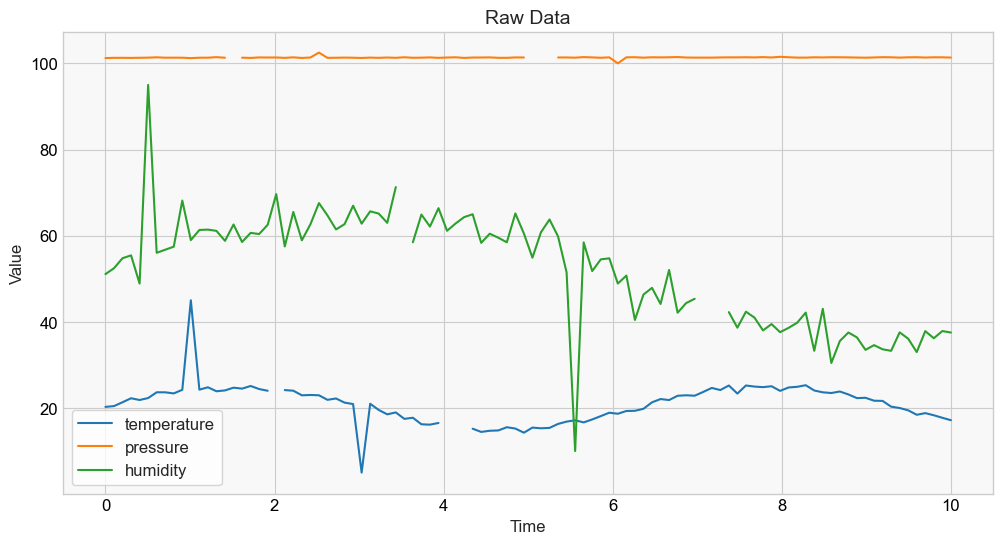

In [3]:
# Create a plot configuration
config = PlotConfig(
    title="Raw Data",
    xlabel="Time",
    ylabel="Value",
    figsize=(12.0, 6.0),
    grid=True
)

# Plot the time series
fig, ax = plot_time_series(data, time, config=config)
plt.show()

We can also look at the distribution of each variable.

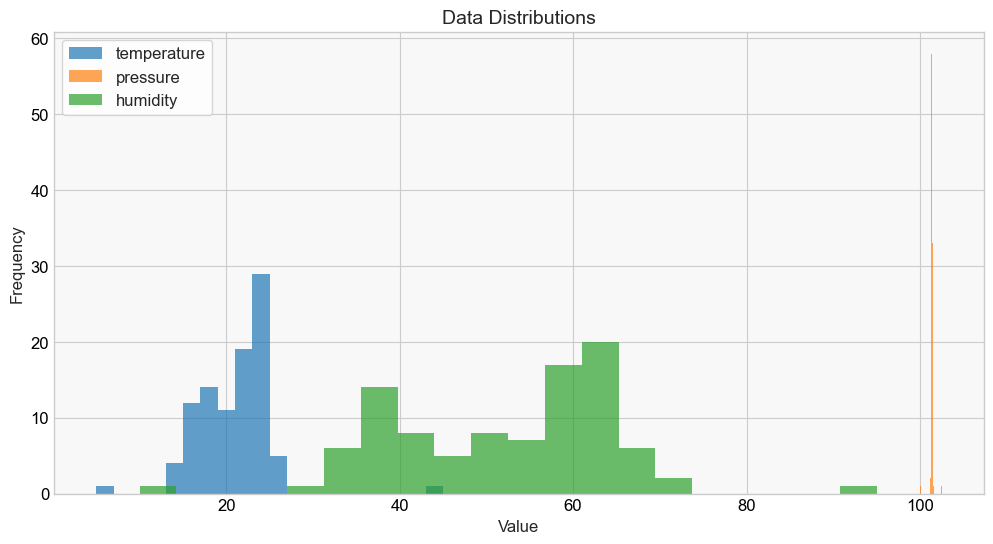

In [4]:
# Create a plot configuration
config = PlotConfig(
    title="Data Distributions",
    xlabel="Value",
    ylabel="Frequency",
    figsize=(12.0, 6.0),
    grid=True
)

# Plot histograms
fig, ax = plot_histogram(data, bins=20, config=config)
plt.show()

And we can examine the box plots to identify potential outliers.

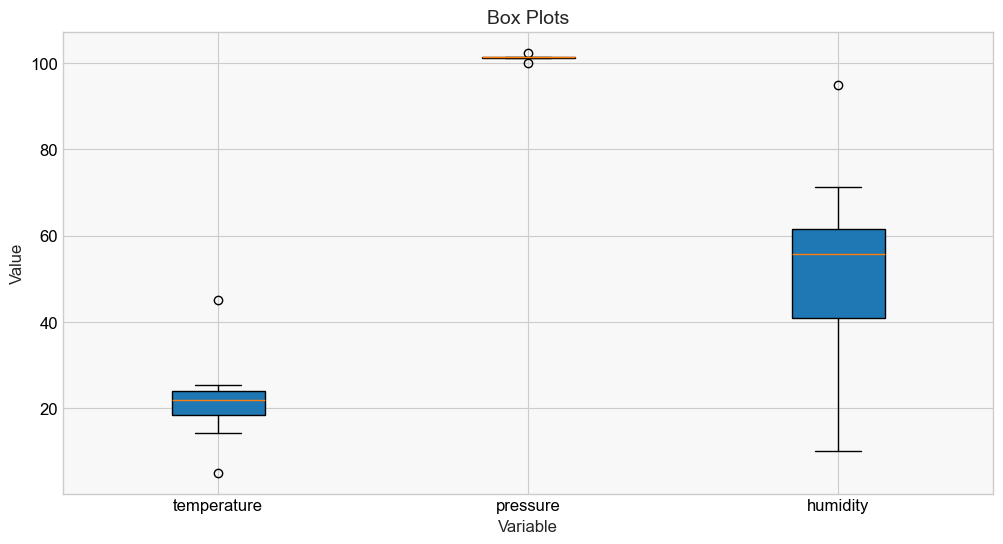

In [5]:
# Create a plot configuration
config = PlotConfig(
    title="Box Plots",
    xlabel="Variable",
    ylabel="Value",
    figsize=(12.0, 6.0),
    grid=True
)

# Plot box plots
fig, ax = plot_boxplot(data, config=config)
plt.show()

## 3. Data Validation

Now that we have our data, let's validate it to identify any issues.

In [6]:
# Validate the data
validation_results = validate_data(
    data,
    checks=["range", "missing", "outliers"],
    params={
        "range": {
            "min_value": 0.0,
            "max_value": 150.0
        },
        "missing": {
            "threshold": 0.05  # Allow up to 5% missing values
        },
        "outliers": {
            "threshold": 2.5,  # Z-score threshold for outliers
            "method": "zscore"
        }
    }
)

# Print validation results
for var_name, result in validation_results.items():
    print(f"Variable: {var_name}")
    print(f"  Valid: {result.is_valid}")
    
    if not result.is_valid:
        print("  Error messages:")
        for msg in result.error_messages:
            print(f"    - {msg}")
    
    if result.statistics:
        print("  Statistics:")
        for key, value in result.statistics.items():
            print(f"    - {key}: {value}")
    
    print()

Variable: temperature
  Valid: True
  Statistics:
    - range_min: nan
    - range_max: nan
    - range_mean: nan
    - range_median: nan
    - range_std: nan
    - missing_missing_count: 4.0
    - missing_missing_fraction: 0.04
    - missing_threshold: 0.05
    - outliers_outlier_count: 2.0
    - outliers_outlier_fraction: 0.02

Variable: pressure
  Valid: True
  Statistics:
    - range_min: nan
    - range_max: nan
    - range_mean: nan
    - range_median: nan
    - range_std: nan
    - missing_missing_count: 4.0
    - missing_missing_fraction: 0.04
    - missing_threshold: 0.05
    - outliers_outlier_count: 2.0
    - outliers_outlier_fraction: 0.02

Variable: humidity
  Valid: True
  Statistics:
    - range_min: nan
    - range_max: nan
    - range_mean: nan
    - range_median: nan
    - range_std: nan
    - missing_missing_count: 4.0
    - missing_missing_fraction: 0.04
    - missing_threshold: 0.05
    - outliers_outlier_count: 2.0
    - outliers_outlier_fraction: 0.02



Let's visualize the validation results to get a better understanding of the issues.

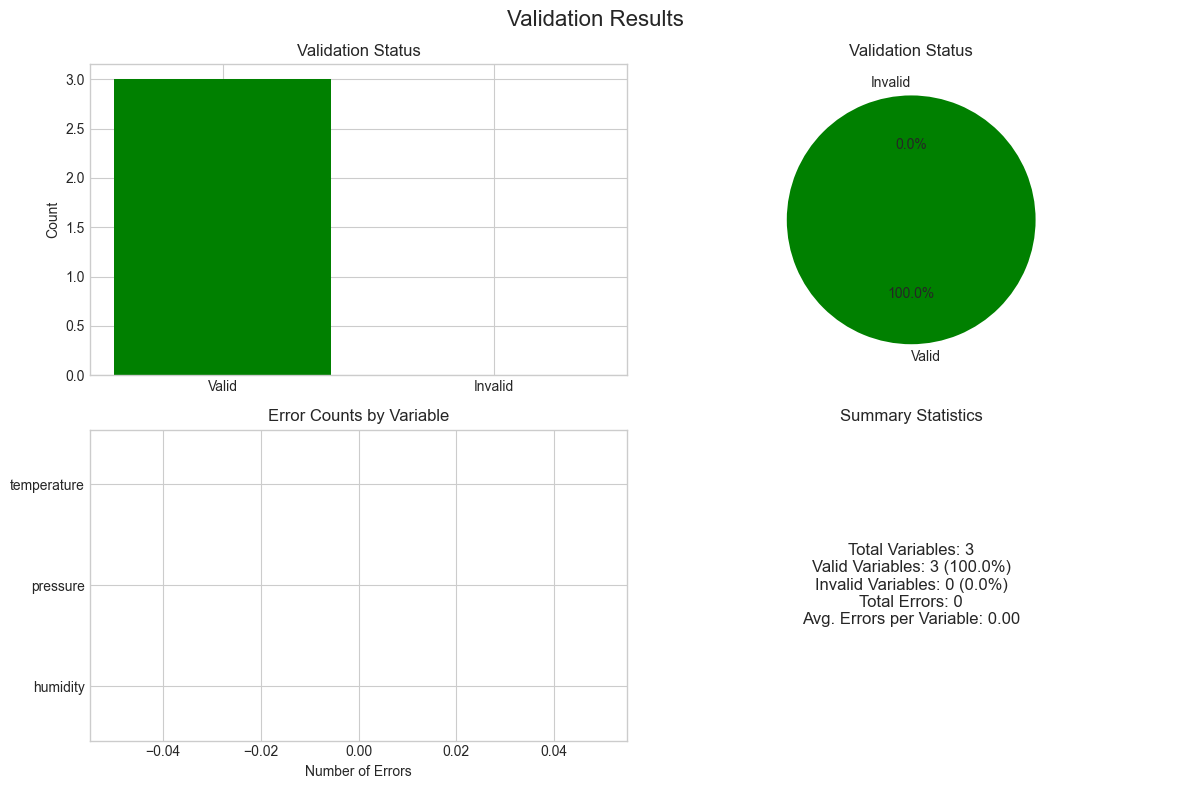

In [7]:
# Convert validation results to a format suitable for plotting
plot_results = {}
for var_name, result in validation_results.items():
    plot_results[var_name] = {
        "is_valid": result.is_valid,
        "error_messages": result.error_messages,
        "statistics": result.statistics or {}
    }

# Plot validation results
fig, axes = plot_validation_results(plot_results)
plt.tight_layout()
plt.show()

## 4. Data Refinement

Now that we have identified issues in our data, let's refine it to address these problems.

In [8]:
# Create a refinement configuration
config = RefinementConfig(
    smoothing_factor=0.2,       # Smoothing factor (0-1, higher = less smoothing)
    outlier_threshold=2.5,      # Z-score threshold for outlier detection
    imputation_method="linear", # Method for imputing missing values
    normalization_type="minmax" # Type of normalization to apply
)

# Refine the data
refined_data = apply_refinement_pipeline(data, config)

# Compare raw and refined data shape
print("Raw data shape:")
for var_name, values in data.items():
    print(f"  {var_name}: {values.shape}")

print("\nRefined data shape:")
for var_name, values in refined_data.items():
    print(f"  {var_name}: {values.shape}")

Raw data shape:
  temperature: (100,)
  pressure: (100,)
  humidity: (100,)

Refined data shape:
  temperature: (100,)
  pressure: (100,)
  humidity: (100,)


Now let's visualize the raw and refined data for each variable to see the effect of our refinement process.

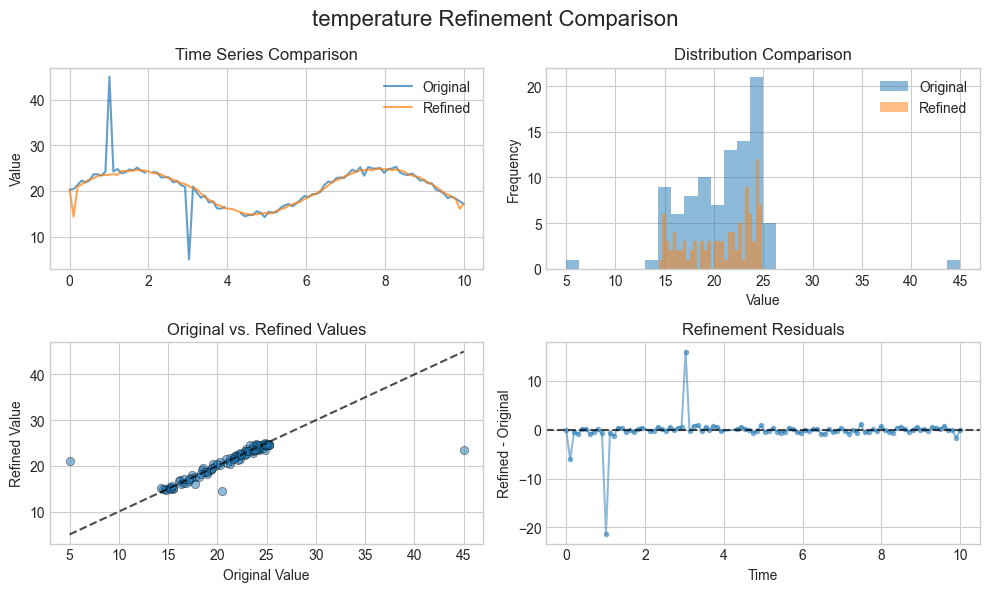

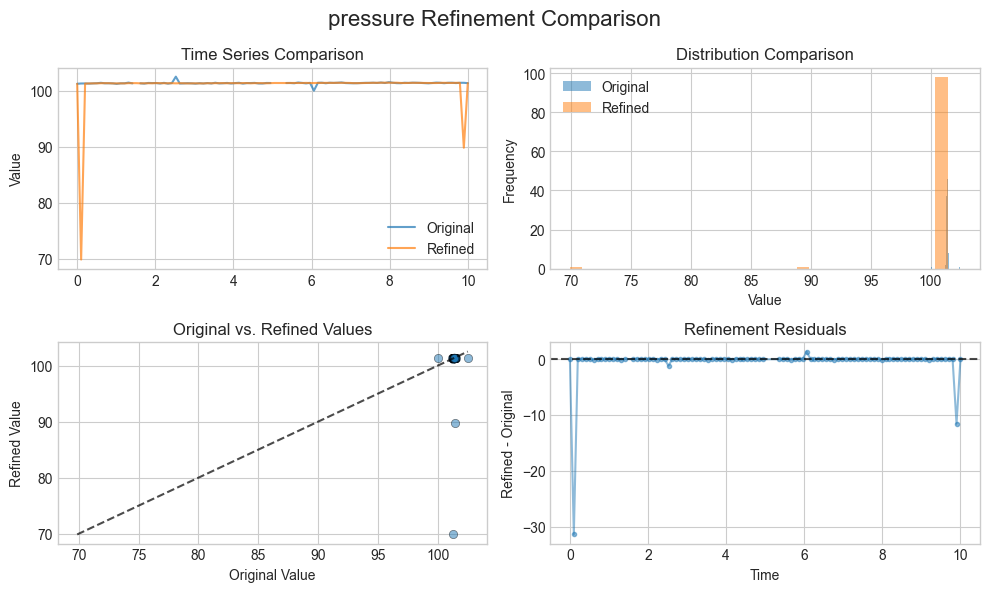

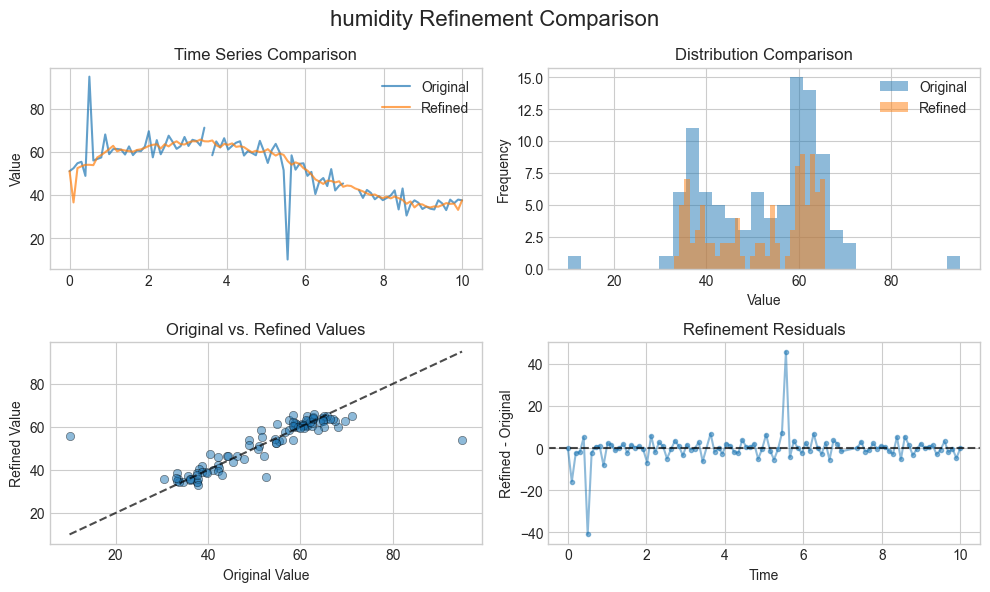

In [9]:
# Visualize refinement for each variable
for var_name in data.keys():
    # Plot refinement comparison
    fig, axes = plot_refinement_comparison(
        data[var_name],
        refined_data[var_name],
        time,
        config=PlotConfig(title=f"{var_name} Refinement Comparison")
    )
    plt.tight_layout()
    plt.show()

## 5. Data Transformation

Now that we have refined our data, let's apply some transformations to it.

In [10]:
# Define transformations
transformations = [
    # First normalize the data to [0, 1] range
    {"type": "normalize", "method": "minmax"},
    
    # Then scale it to [1, 3] range (multiply by 2 and add 1)
    {"type": "scale", "factor": 2.0, "offset": 1.0}
]

# Apply transformations to each variable
transformed_data = {}
for var_name, values in refined_data.items():
    transformed_data[var_name] = transform_data(values, transformations)

# Compare the data statistics before and after transformation
for var_name in data.keys():
    raw = data[var_name]
    refined = refined_data[var_name]
    transformed = transformed_data[var_name]
    
    print(f"Variable: {var_name}")
    print(f"  Raw:         min={np.nanmin(raw):.2f}, max={np.nanmax(raw):.2f}, mean={np.nanmean(raw):.2f}, std={np.nanstd(raw):.2f}")
    print(f"  Refined:     min={np.min(refined):.2f}, max={np.max(refined):.2f}, mean={np.mean(refined):.2f}, std={np.std(refined):.2f}")
    print(f"  Transformed: min={np.min(transformed):.2f}, max={np.max(transformed):.2f}, mean={np.mean(transformed):.2f}, std={np.std(transformed):.2f}")
    print()

Variable: temperature
  Raw:         min=5.00, max=45.00, mean=21.01, std=4.39
  Refined:     min=14.39, max=24.92, mean=20.75, std=3.35
  Transformed: min=1.00, max=3.00, mean=2.21, std=0.64

Variable: pressure
  Raw:         min=100.00, max=102.50, mean=101.35, std=0.19
  Refined:     min=69.87, max=101.42, mean=100.92, std=3.33
  Transformed: min=1.00, max=3.00, mean=2.97, std=0.21

Variable: humidity
  Raw:         min=10.00, max=95.00, mean=52.34, std=12.75
  Refined:     min=33.08, max=65.75, mean=52.12, std=10.88
  Transformed: min=1.00, max=3.00, mean=2.17, std=0.67



Let's visualize the transformed data.

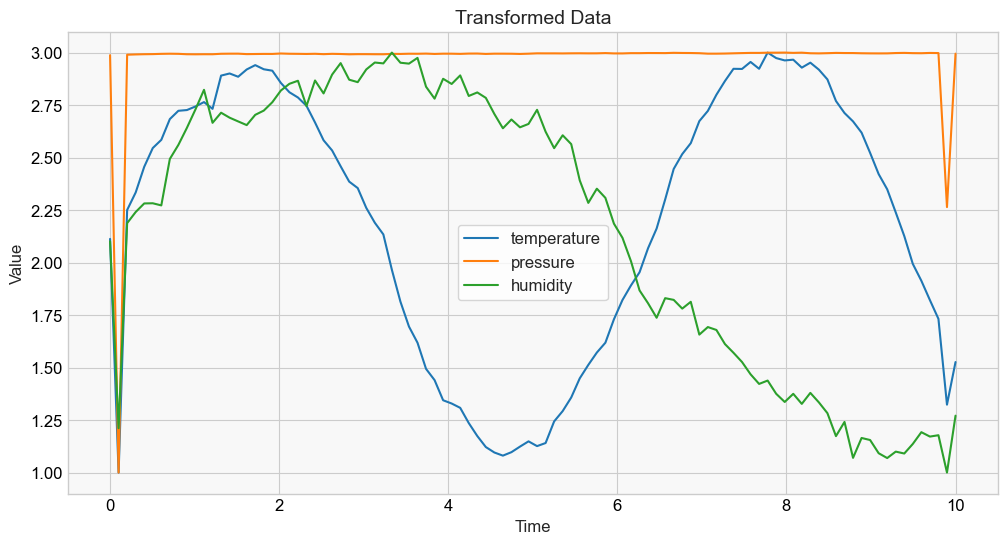

In [11]:
# Create a plot configuration
config = PlotConfig(
    title="Transformed Data",
    xlabel="Time",
    ylabel="Value",
    figsize=(12.0, 6.0),
    grid=True
)

# Plot the transformed time series
fig, ax = plot_time_series(transformed_data, time, config=config)
plt.show()

## 6. Visualization

MDR provides various visualization functions. Let's explore some of them.

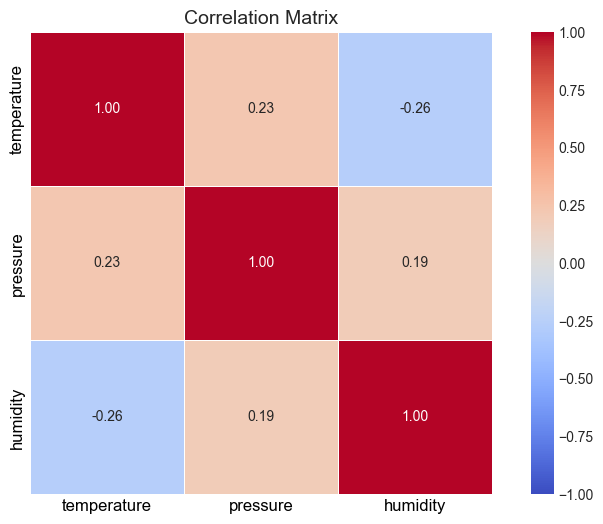

In [12]:
# Create a correlation matrix of the refined data
from mdr.visualization.plots import plot_correlation_matrix

# Create a DataFrame from the refined data
refined_df = pd.DataFrame(refined_data)

# Plot correlation matrix
fig, ax = plot_correlation_matrix(
    refined_df,
    method="pearson",
    cmap="coolwarm",
    config=PlotConfig(title="Correlation Matrix")
)
plt.show()

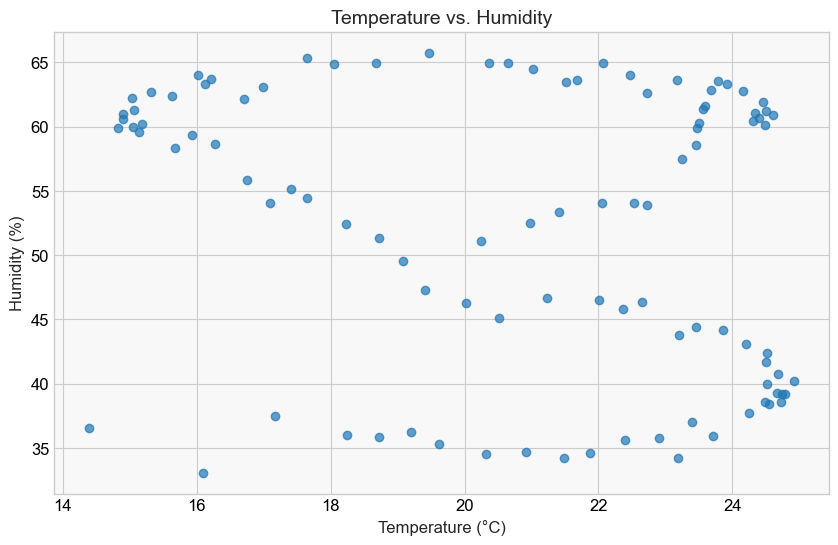

In [13]:
# Create a scatter plot of temperature vs. humidity
from mdr.visualization.plots import plot_scatter

# Plot scatter
fig, ax = plot_scatter(
    refined_data["temperature"],
    refined_data["humidity"],
    config=PlotConfig(
        title="Temperature vs. Humidity",
        xlabel="Temperature (°C)",
        ylabel="Humidity (%)"
    )
)
plt.show()

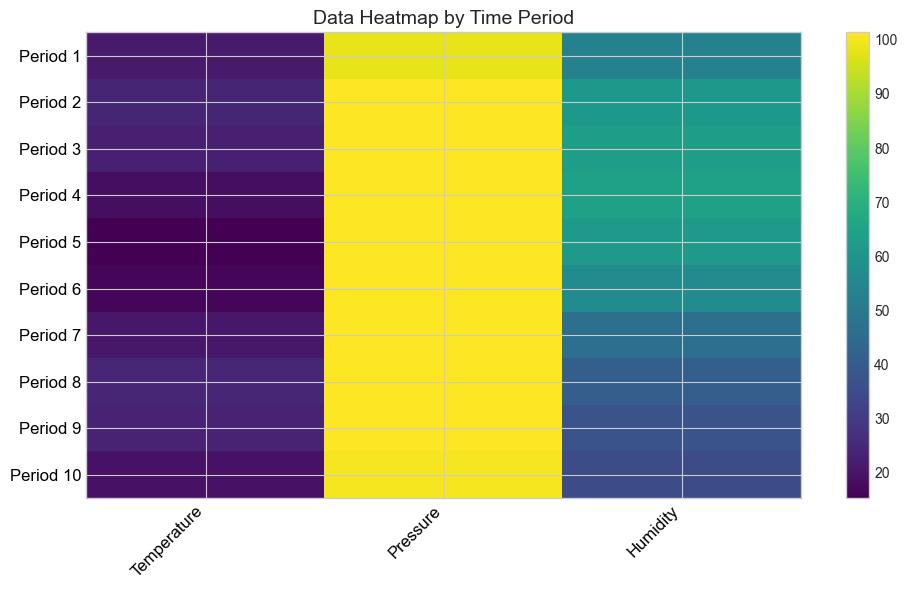

In [14]:
# Create a heatmap of the data over time (resampled)
from mdr.visualization.plots import plot_heatmap

# Create a resampled view of the data (10 time periods x 3 variables)
num_periods = 10
period_length = len(time) // num_periods
heatmap_data = np.zeros((num_periods, 3))

for i in range(num_periods):
    start_idx = i * period_length
    end_idx = (i + 1) * period_length
    
    heatmap_data[i, 0] = np.mean(refined_data["temperature"][start_idx:end_idx])
    heatmap_data[i, 1] = np.mean(refined_data["pressure"][start_idx:end_idx])
    heatmap_data[i, 2] = np.mean(refined_data["humidity"][start_idx:end_idx])

# Create row and column labels
row_labels = [f"Period {i+1}" for i in range(num_periods)]
col_labels = ["Temperature", "Pressure", "Humidity"]

# Plot heatmap
fig, ax = plot_heatmap(
    heatmap_data,
    row_labels=row_labels,
    col_labels=col_labels,
    cmap="viridis",
    config=PlotConfig(title="Data Heatmap by Time Period")
)
plt.tight_layout()
plt.show()

## 7. File I/O

MDR provides functions for reading and writing data in various formats. Let's demonstrate some of them.

In [15]:
# Save the refined data to CSV
csv_path = os.path.join(output_dir, "refined_data.csv")

# Add time to the refined data for CSV export
refined_with_time = refined_data.copy()
refined_with_time["time"] = time

# Write to CSV
write_csv(refined_with_time, csv_path)
print(f"Refined data saved to: {csv_path}")

# Read the CSV file back
read_data = read_csv(csv_path)
print(f"Read data shape: {len(read_data)} variables")
print(f"Variables: {list(read_data.keys())}")

Refined data saved to: mdr_notebook_output/refined_data.csv
Read data shape: 4 variables
Variables: ['temperature', 'pressure', 'humidity', 'time']


In [16]:
# Save the transformed data to JSON
json_path = os.path.join(output_dir, "transformed_data.json")

# Add time to the transformed data for JSON export
transformed_with_time = transformed_data.copy()
transformed_with_time["time"] = time

# Write to JSON
write_json(transformed_with_time, json_path)
print(f"Transformed data saved to: {json_path}")

# Read the JSON file back
read_json_data = read_json(json_path)
print(f"Read data shape: {len(read_json_data)} variables")
print(f"Variables: {list(read_json_data.keys())}")

Transformed data saved to: mdr_notebook_output/transformed_data.json
Read data shape: 4 variables
Variables: ['temperature', 'pressure', 'humidity', 'time']


## 8. End-to-End Workflow

Now let's put everything together in an end-to-end workflow.

In [17]:
def process_data(data: Dict[str, np.ndarray], time: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Process data through a complete MDR workflow.
    
    Args:
        data: Dictionary of variable names to data arrays
        time: Array of time points
        
    Returns:
        Dictionary of processed data
    """
    assert isinstance(data, dict), "data must be a dictionary"
    assert all(isinstance(k, str) for k in data.keys()), "data keys must be strings"
    assert all(isinstance(v, np.ndarray) for v in data.values()), "data values must be numpy arrays"
    assert isinstance(time, np.ndarray), "time must be a numpy array"
    
    # Step 1: Validate the data
    print("Step 1: Validating data...")
    validation_results = validate_data(
        data,
        checks=["range", "missing", "outliers"]
    )
    
    # Print validation summary
    valid_count = sum(1 for result in validation_results.values() if result.is_valid)
    print(f"Validation summary: {valid_count}/{len(validation_results)} variables passed validation")
    
    # Step 2: Refine the data
    print("\nStep 2: Refining data...")
    config = RefinementConfig(
        smoothing_factor=0.2,
        outlier_threshold=2.5,
        imputation_method="linear",
        normalization_type="minmax"
    )
    
    refined_data = apply_refinement_pipeline(data, config)
    print(f"Refinement complete. Processed {len(refined_data)} variables.")
    
    # Step 3: Verify refinement results
    print("\nStep 3: Verifying refinement results...")
    for var_name, values in refined_data.items():
        # Check for missing values
        missing_count = np.isnan(values).sum()
        print(f"  {var_name}: {missing_count} missing values")
        
        # Check for extreme outliers
        z_scores = np.abs((values - np.mean(values)) / np.std(values))
        extreme_outliers = (z_scores > 3.0).sum()
        print(f"  {var_name}: {extreme_outliers} extreme outliers")
    
    # Step 4: Apply transformations
    print("\nStep 4: Applying transformations...")
    transformations = [
        {"type": "normalize", "method": "minmax"},
        {"type": "scale", "factor": 2.0, "offset": 1.0}
    ]
    
    transformed_data = {}
    for var_name, values in refined_data.items():
        transformed_data[var_name] = transform_data(values, transformations)
    
    print(f"Transformation complete. Processed {len(transformed_data)} variables.")
    
    # Return the processed data
    return transformed_data

# Process our sample data
processed_data = process_data(data, time)

Step 1: Validating data...
Validation summary: 3/3 variables passed validation

Step 2: Refining data...
Refinement complete. Processed 3 variables.

Step 3: Verifying refinement results...
  temperature: 0 missing values
  temperature: 0 extreme outliers
  pressure: 0 missing values
  pressure: 2 extreme outliers
  humidity: 0 missing values
  humidity: 0 extreme outliers

Step 4: Applying transformations...
Transformation complete. Processed 3 variables.


Let's compare the raw, refined, and processed data.

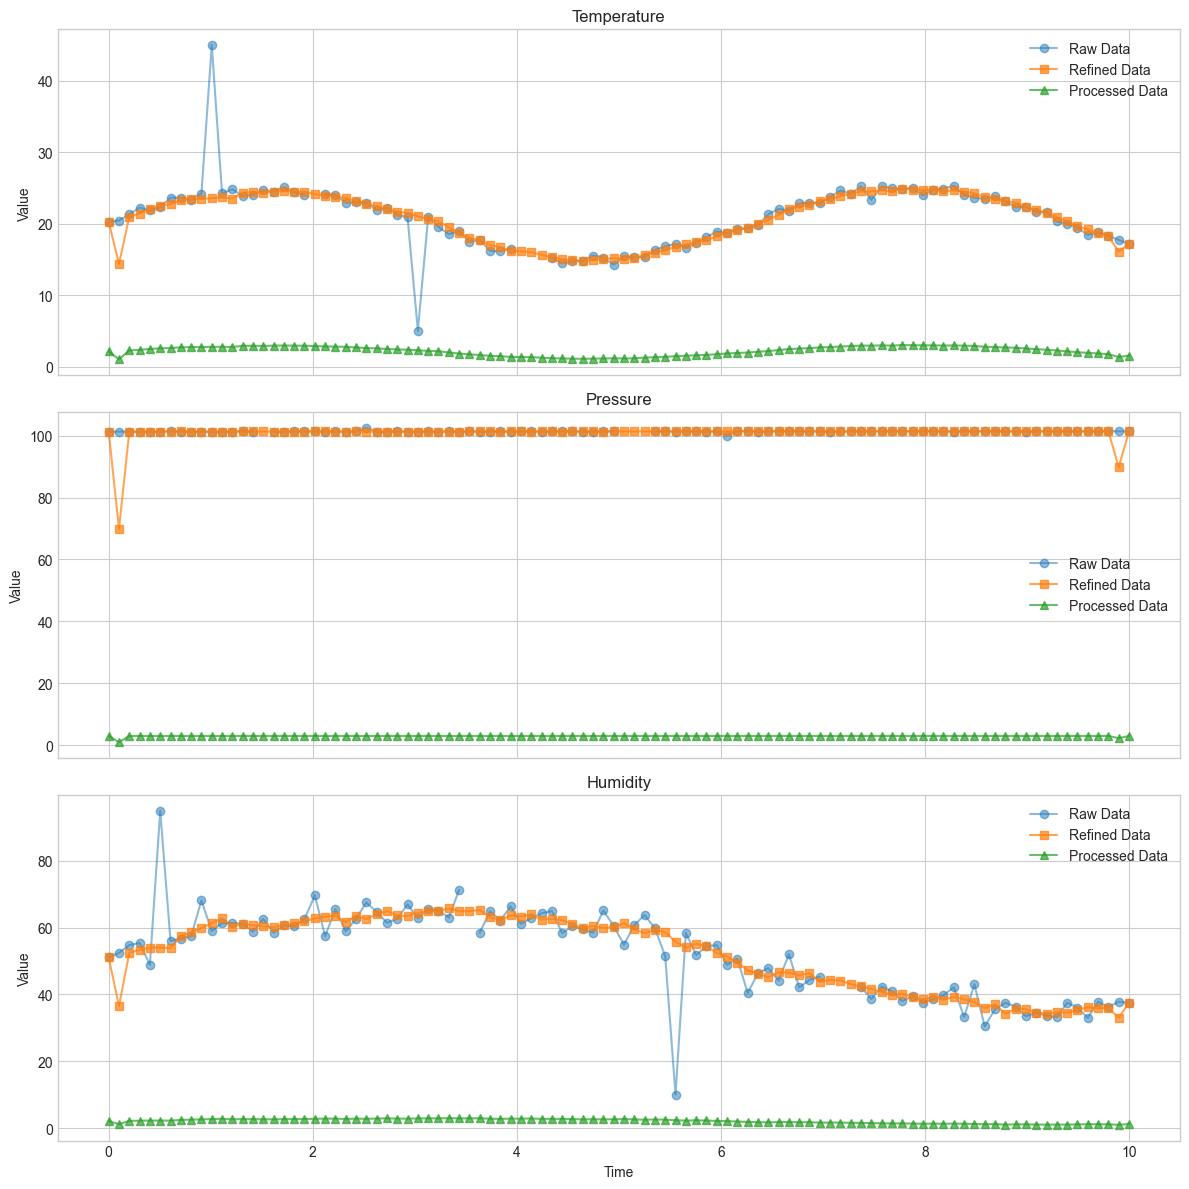

In [18]:
# Create a figure with 3 subplots (one for each variable)
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

variables = list(data.keys())
titles = ["Temperature", "Pressure", "Humidity"]

for i, (var_name, title) in enumerate(zip(variables, titles)):
    ax = axes[i]
    
    # Plot raw data
    ax.plot(time, data[var_name], 'o-', alpha=0.5, label="Raw Data")
    
    # Plot refined data
    ax.plot(time, refined_data[var_name], 's-', alpha=0.7, label="Refined Data")
    
    # Plot processed data
    ax.plot(time, processed_data[var_name], '^-', alpha=0.7, label="Processed Data")
    
    ax.set_title(title)
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Set common x-axis label
axes[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()

## 9. Advanced Usage

Now let's explore some more advanced features of MDR.

### 9.1. Seasonality Detection

MDR provides utilities for detecting seasonality in time series data.

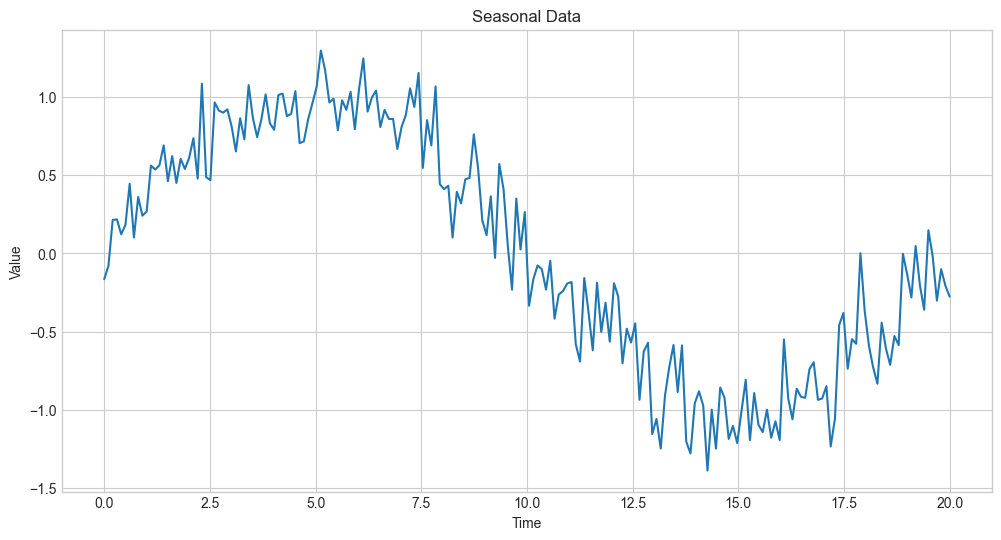

Is seasonal: True
Detected period: 10
Actual period: 20


In [19]:
# Create a dataset with clear seasonality
num_points = 200
t = np.linspace(0, 20, num_points)
seasonal_period = 20  # Period of 20 points

# Create a seasonal pattern with noise
seasonal_data = np.sin(2 * np.pi * t / seasonal_period) + 0.2 * np.random.randn(num_points)

# Plot the seasonal data
plt.figure(figsize=(12, 6))
plt.plot(t, seasonal_data)
plt.title("Seasonal Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Detect seasonality
is_seasonal, detected_period = detect_seasonality(
    seasonal_data,
    max_lag=50,     # Maximum lag to consider
    threshold=0.3   # Correlation threshold
)

print(f"Is seasonal: {is_seasonal}")
if is_seasonal:
    print(f"Detected period: {detected_period}")
    print(f"Actual period: {seasonal_period}")

### 9.2. Custom Transformations

MDR allows you to apply custom transformations to your data.

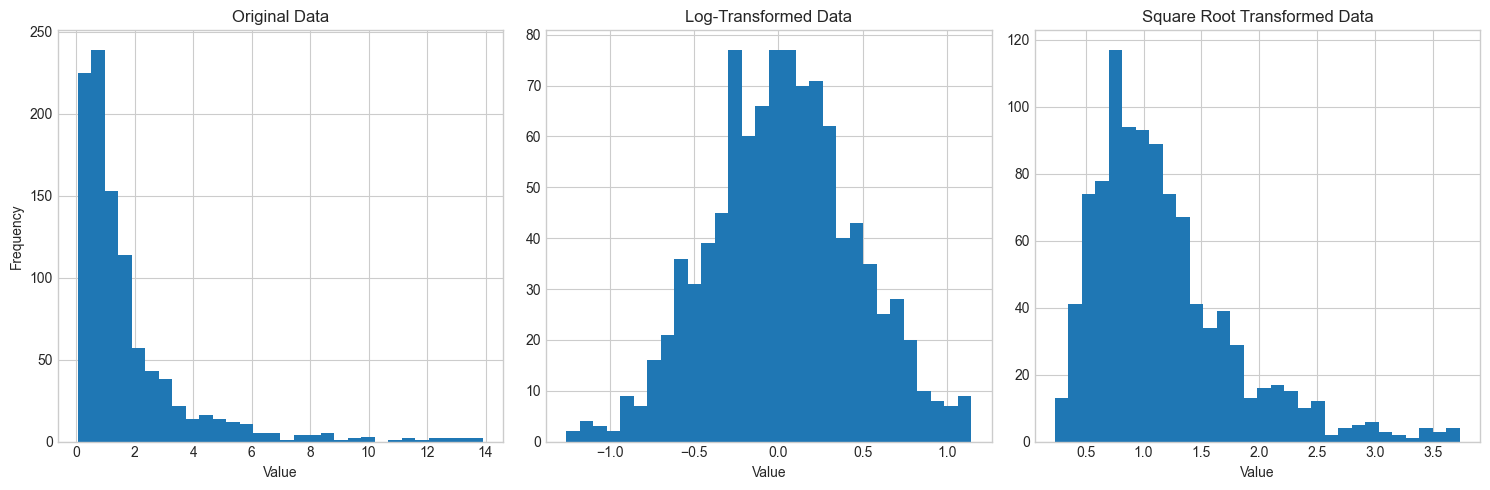

In [20]:
# Import required functions
from mdr.core.transformation import (
    apply_logarithmic_transform,
    apply_power_transform,
    transform_data
)

# Create sample data with positively skewed distribution
skewed_data = np.random.lognormal(mean=0, sigma=1, size=1000)

# Apply logarithmic transformation
log_data = apply_logarithmic_transform(skewed_data, base=10.0, epsilon=1e-10)

# Apply power transformation (square root, which is power=0.5)
sqrt_data = apply_power_transform(skewed_data, power=0.5, preserve_sign=True)

# Plot the original and transformed distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original data
axes[0].hist(skewed_data, bins=30)
axes[0].set_title("Original Data")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# Log-transformed data
axes[1].hist(log_data, bins=30)
axes[1].set_title("Log-Transformed Data")
axes[1].set_xlabel("Value")

# Square root transformed data
axes[2].hist(sqrt_data, bins=30)
axes[2].set_title("Square Root Transformed Data")
axes[2].set_xlabel("Value")

plt.tight_layout()
plt.show()

### 9.3. Custom Refinement Pipeline

Let's create a custom refinement pipeline for a specific dataset.

/Users/mudit/Developer/macrodata-refinement/src/mdr/core/refinement.py:150: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imputed_data = pd.Series(imputed_data).fillna(method='ffill').values


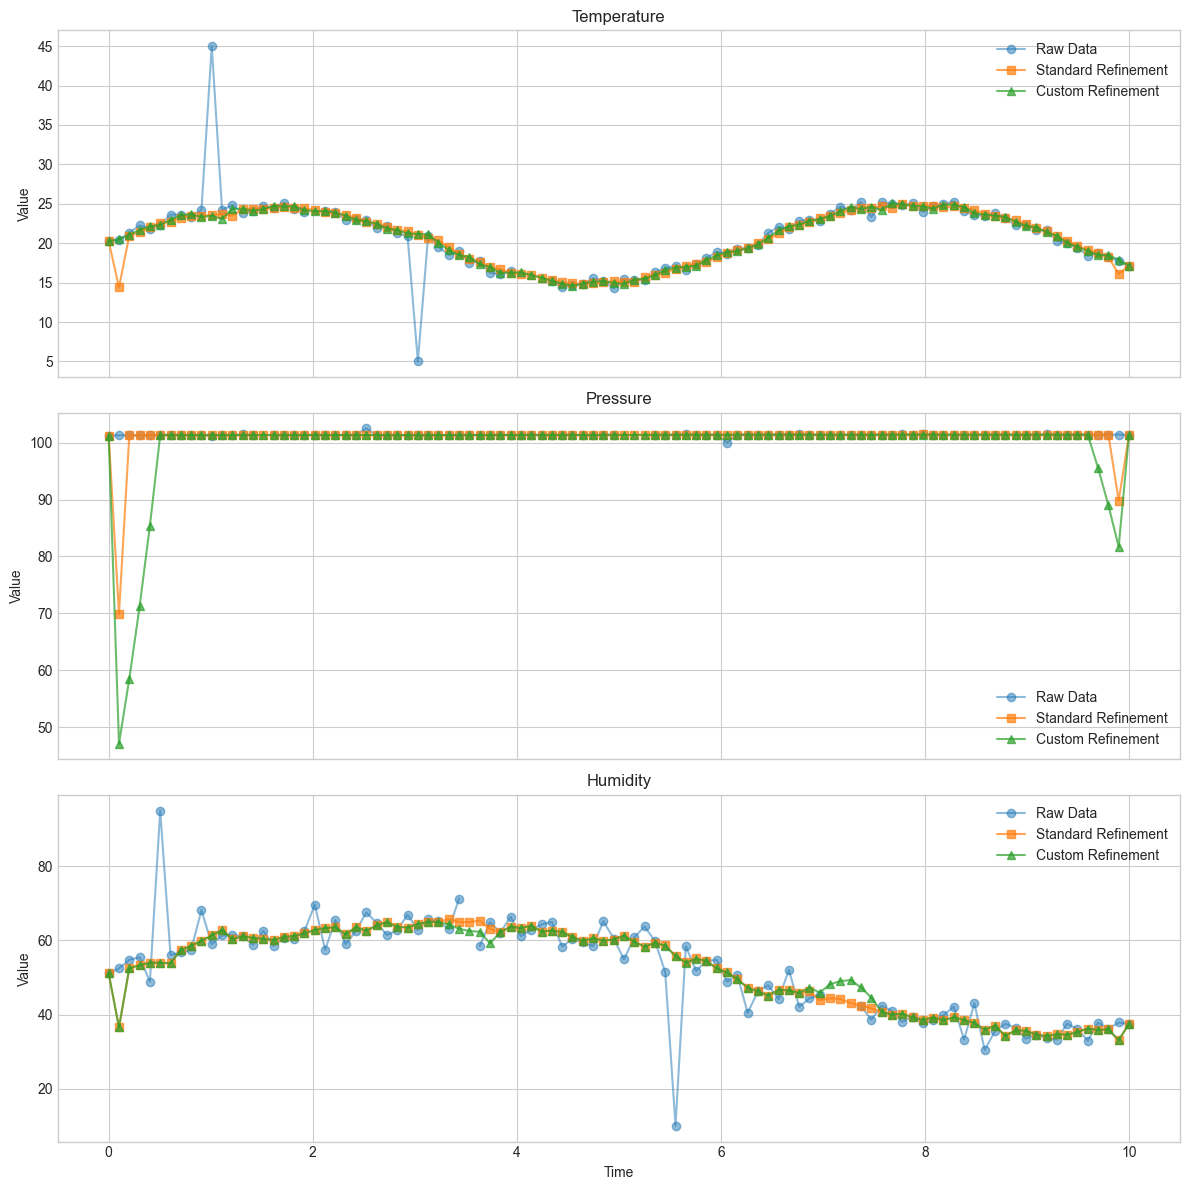

In [21]:
def custom_refinement_pipeline(data: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    Custom refinement pipeline for specific data needs.
    
    Args:
        data: Dictionary of variable names to data arrays
        
    Returns:
        Dictionary of refined data
    """
    assert isinstance(data, dict), "data must be a dictionary"
    assert all(isinstance(k, str) for k in data.keys()), "data keys must be strings"
    assert all(isinstance(v, np.ndarray) for v in data.values()), "data values must be numpy arrays"
    
    # Import necessary functions
    from mdr.core.refinement import remove_outliers, impute_missing_values, smooth_data
    
    # Create a copy of the input data
    refined = {}
    
    for var_name, values in data.items():
        # Step 1: Impute missing values (method depends on the variable)
        if var_name == "temperature":
            # For temperature, use linear interpolation
            imputed = impute_missing_values(values, method="linear")
        elif var_name == "pressure":
            # For pressure, use forward fill (last observation carried forward)
            imputed = impute_missing_values(values, method="forward")
        else:
            # For other variables, use mean imputation
            imputed = impute_missing_values(values, method="mean")
        
        # Step 2: Remove outliers (threshold depends on the variable)
        if var_name == "temperature":
            # Temperature can have more natural variation, so use a higher threshold
            no_outliers = remove_outliers(imputed, threshold=3.0)
        elif var_name == "pressure":
            # Pressure should be more stable, so use a lower threshold
            no_outliers = remove_outliers(imputed, threshold=2.0)
        else:
            # For other variables, use a medium threshold
            no_outliers = remove_outliers(imputed, threshold=2.5)
        
        # Step 3: Smooth the data (factor depends on the variable)
        if var_name == "temperature":
            # Less smoothing for temperature
            smoothed = smooth_data(no_outliers, factor=0.3)
        elif var_name == "pressure":
            # More smoothing for pressure
            smoothed = smooth_data(no_outliers, factor=0.1)
        else:
            # Medium smoothing for other variables
            smoothed = smooth_data(no_outliers, factor=0.2)
        
        # Store the refined variable
        refined[var_name] = smoothed
    
    return refined

# Apply the custom refinement pipeline to our data
custom_refined = custom_refinement_pipeline(data)

# Compare with the standard refinement pipeline
standard_config = RefinementConfig(
    smoothing_factor=0.2,
    outlier_threshold=2.5,
    imputation_method="linear",
    normalization_type="minmax"
)
standard_refined = apply_refinement_pipeline(data, standard_config)

# Plot the comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

variables = list(data.keys())
titles = ["Temperature", "Pressure", "Humidity"]

for i, (var_name, title) in enumerate(zip(variables, titles)):
    ax = axes[i]
    
    # Plot raw data
    ax.plot(time, data[var_name], 'o-', alpha=0.5, label="Raw Data")
    
    # Plot standard refinement
    ax.plot(time, standard_refined[var_name], 's-', alpha=0.7, label="Standard Refinement")
    
    # Plot custom refinement
    ax.plot(time, custom_refined[var_name], '^-', alpha=0.7, label="Custom Refinement")
    
    ax.set_title(title)
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Set common x-axis label
axes[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've explored the key features of the Macrodata Refinement (MDR) library:

1. Data Validation - Identifying issues in the data
2. Data Refinement - Fixing issues like outliers and missing values
3. Data Transformation - Converting data to a desired format or scale
4. Visualization - Creating various plots to understand the data
5. File I/O - Reading and writing data in different formats
6. Advanced Features - Seasonality detection, custom transformations, etc.

MDR provides a comprehensive toolkit for working with macrodata, making it easy to clean, validate, transform, and visualize your data.